# SIO 236 - Lab V : Image Processing

### Bia Villas Bôas - avillasb@ucsd.edu


In [1]:
% matplotlib inline

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
import cv2
from scipy.signal import convolve2d

## Exercise 2

#### It is very likely that the features we see in the ocean are suspended material, being either biological tracers or sediment.  

In [52]:
band6 = '/Users/bia/work/PhD/coursework/Spring2016/SIO236/labs/lab05/band6c.raw' # file for the infrared band
fbin6 = np.fromfile(band6,dtype='int8') # reading binary file
data6 = np.array(np.reshape(fbin6, (1500,1500))) #reshaping
s = 3 # slope
lin6 = s*data6 # linear stretch 

In [53]:
def image_histogram_equalization(image, number_bins=256):

    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf

data6_eq, cdf = image_histogram_equalization(data6, number_bins=256)

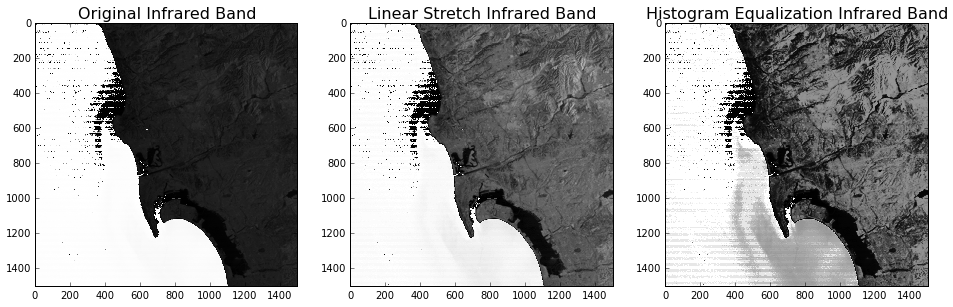

In [54]:
plt.figure(figsize=(16,6))
plt.subplot(131)
plt.imshow(data6, cmap = cm.gray)
plt.title('Original Infrared Band', fontsize=16)
plt.subplot(132)
plt.imshow(lin6, cmap = cm.gray)
plt.title('Linear Stretch Infrared Band', fontsize=16)
plt.subplot(133)
plt.imshow(data6_eq, cmap=cm.gray)
plt.title('Histogram Equalization Infrared Band', fontsize=16)
plt.savefig('band6_strech_equalization.png', dpi=300)

#### Plotting the equalized histograms

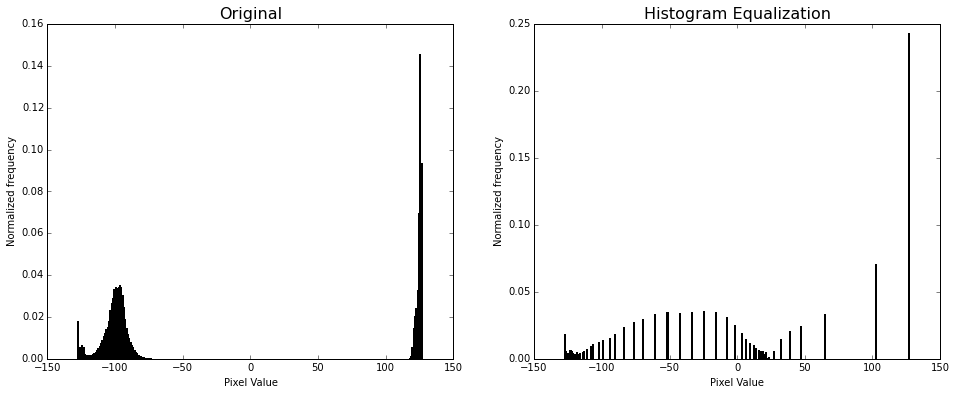

In [55]:
hist_eq, bins_eq = np.histogram(data6_eq,bins=256,normed=True)
hist_data6, bins = np.histogram(data6,bins=256,normed=True)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.bar(bins[:-1],hist_data6, color='black')
plt.title('Original', fontsize=16)
plt.xlabel('Pixel Value')
plt.ylabel('Normalized frequency')
plt.subplot(122)
plt.bar(bins[:-1],hist_eq, color='black')
plt.title('Histogram Equalization', fontsize=16)
plt.xlabel('Pixel Value')
plt.ylabel('Normalized frequency')
plt.savefig('band6_histograms.png')

## Exercise 3

#### RGB bands from Landsat are measured by passive sensors, thus it captures the incoming radiation from the Sun that is reflected by the Earth. The blueish colors in the original image are a consequence of the sun emitting more radiation in the green-blue bands of the specrtum.

In [56]:
band1 = '/Users/bia/work/PhD/coursework/Spring2016/SIO236/labs/lab05/band1c.raw'
fbin1 = np.fromfile(band1,dtype='int8')
b = np.array(np.reshape(fbin1, (1500,1500)))

band2 = '/Users/bia/work/PhD/coursework/Spring2016/SIO236/labs/lab05/band2c.raw'
fbin2 = np.fromfile(band2,dtype='int8')
g = np.array(np.reshape(fbin2, (1500,1500)))

band3 = '/Users/bia/work/PhD/coursework/Spring2016/SIO236/labs/lab05/band3c.raw'
fbin3 = np.fromfile(band3,dtype='int8')
r = np.array(np.reshape(fbin3, (1500,1500)))

# Saving the image that combines the three bands
recover = Image.fromarray(np.stack([r,g,b], axis=2), mode='RGB')
recover.save("rgb_sandiego.jpg")

In [60]:
bgr_san = cv2.imread('rgb_sandiego.jpg')
B,G,R = cv2.split(bgr_san)
rgb_san = cv2.merge([R,G,B])

# Equalizing each band
blue_eq = cv2.equalizeHist(B)
red_eq = cv2.equalizeHist(R)
green_eq = cv2.equalizeHist(G)

# Combining the equalized bands into an RGB image
rgb_eq = Image.fromarray(np.stack([red_eq,green_eq,blue_eq], axis=2), mode='RGB')
rgb_eq.save('rgb_sandiego_eq.jpg')

In [61]:
# Original Histograms for each band
hist_r, bins = np.histogram(R,bins=256,normed=True)
hist_g, bins = np.histogram(G,bins=256,normed=True)
hist_b, bins = np.histogram(B,bins=256,normed=True)
# Equalized Histograms
hist_req, bins = np.histogram(red_eq,bins=256,normed=True)
hist_geq, bins = np.histogram(green_eq,bins=256,normed=True)
hist_beq, bins = np.histogram(blue_eq,bins=256,normed=True)

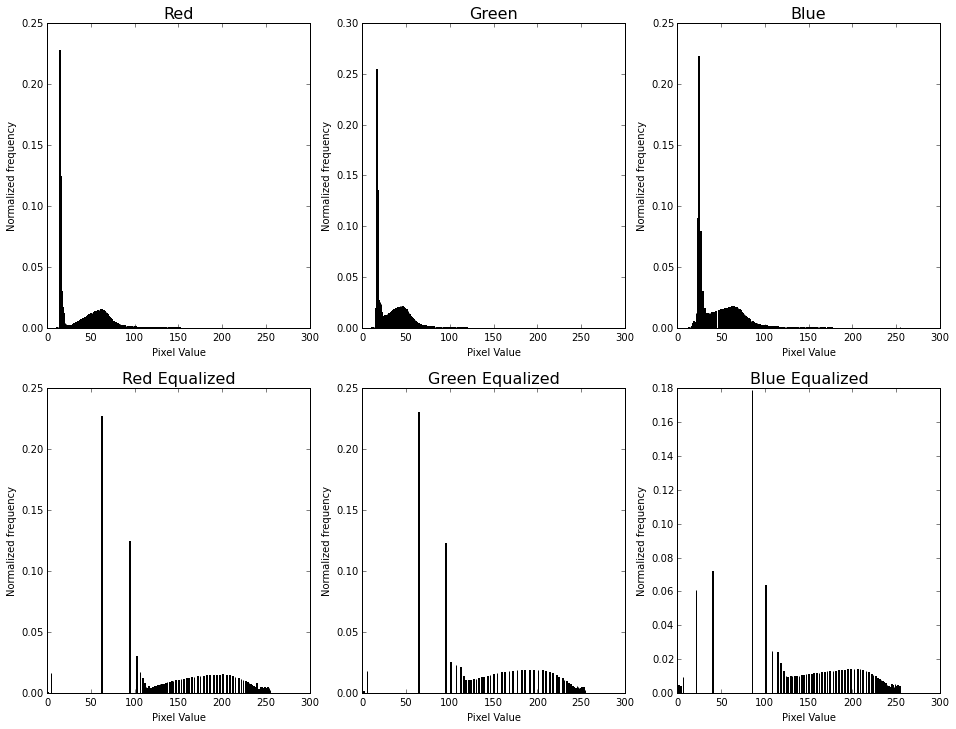

In [62]:
plt.figure(figsize=(16,12))
plt.subplot(231)
plt.bar(bins[:-1],hist_r, color='black')
plt.title('Red', fontsize=16)
plt.xlabel('Pixel Value')
plt.ylabel('Normalized frequency')
plt.subplot(232)
plt.bar(bins[:-1],hist_g, color='black')
plt.title('Green', fontsize=16)
plt.xlabel('Pixel Value')
plt.ylabel('Normalized frequency')
plt.subplot(233)
plt.bar(bins[:-1],hist_b, color='black')
plt.title('Blue', fontsize=16)
plt.xlabel('Pixel Value')
plt.ylabel('Normalized frequency')
plt.subplot(234)
plt.bar(bins[:-1],hist_req, color='black')
plt.title('Red Equalized', fontsize=16)
plt.xlabel('Pixel Value')
plt.ylabel('Normalized frequency')
plt.subplot(235)
plt.bar(bins[:-1],hist_geq, color='black')
plt.title('Green Equalized', fontsize=16)
plt.xlabel('Pixel Value')
plt.ylabel('Normalized frequency')
plt.subplot(236)
plt.bar(bins[:-1],hist_beq, color='black')
plt.title('Blue Equalized', fontsize=16)
plt.xlabel('Pixel Value')
plt.ylabel('Normalized frequency')
plt.savefig('rgb_histograms.png')

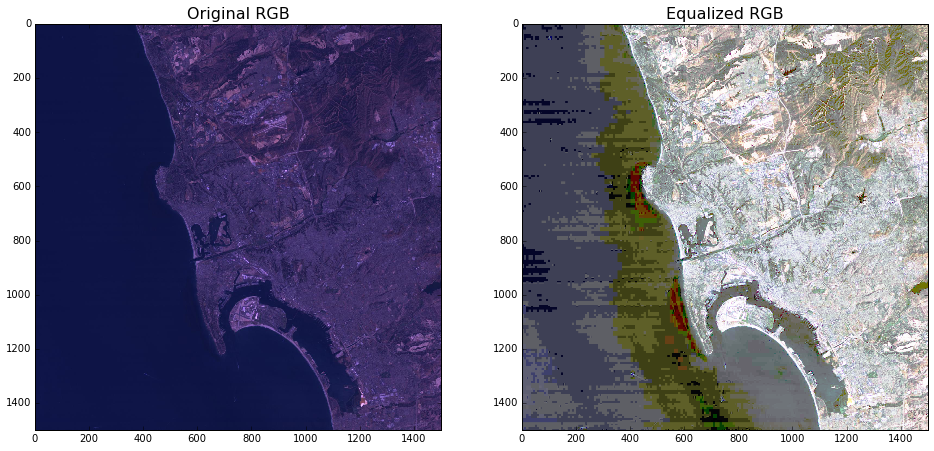

In [50]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(rgb_san)
plt.title('Original RGB', fontsize=16)
plt.subplot(122)
plt.imshow(rgb_eq)
plt.title('Equalized RGB', fontsize=16)
plt.savefig('rgb_orig_eq.png', dpi=300)

## Exercise 4

#### Using the convolution theorem to filter faster

In [65]:
data1 = '/Users/bia/work/PhD/coursework/Spring2016/SIO236/labs/lab05/band1c.raw' # file for the infrared band
fbin1 = np.fromfile(data1,dtype='int8') # reading binary file
band1 = np.array(np.reshape(fbin1, (1500,1500))) #reshaping

In [66]:
smoothfilt = np.array([[1./9, 1./9, 1./9],[1./9, 1./9, 1./9],[1./9, 1./9, 1./9]])
sx,sy = smoothfilt.shape
window_smooth = np.zeros(band1.shape)
window_smooth[:sx,:sy] =  smoothfilt
fft_window_smooth = np.fft.fft2(window_smooth)
fft_band1 = np.fft.fft2(band1)
conv_smooth = fft_band1*fft_window_smooth
band1_smooth = np.fft.ifft2(conv_smooth).real

sharpfilt = np.array([[-1./9, -1./9, -1./9],[-1./9, 17./9, -1./9],[-1./9, -1./9, -1./9]])
sx,sy = sharpfilt.shape
window_sharp = np.zeros(band1.shape)
window_sharp[:sx,:sy] =  sharpfilt
fft_window_sharp = np.fft.fft2(window_sharp)
conv_sharp = fft_band1*fft_window_sharp
band1_sharp = np.fft.ifft2(conv_sharp).real

swfilt = np.array([[0, 1., 2.],[-1., 0, 1.],[-2., -1., 0]])
sx,sy = swfilt.shape
window_sw = np.zeros(band1.shape)
window_sw[:sx,:sy] =  swfilt
fft_window_sw = np.fft.fft2(window_sw)
conv_sw = fft_band1*fft_window_sw
band1_sw = np.fft.ifft2(conv_sw).real


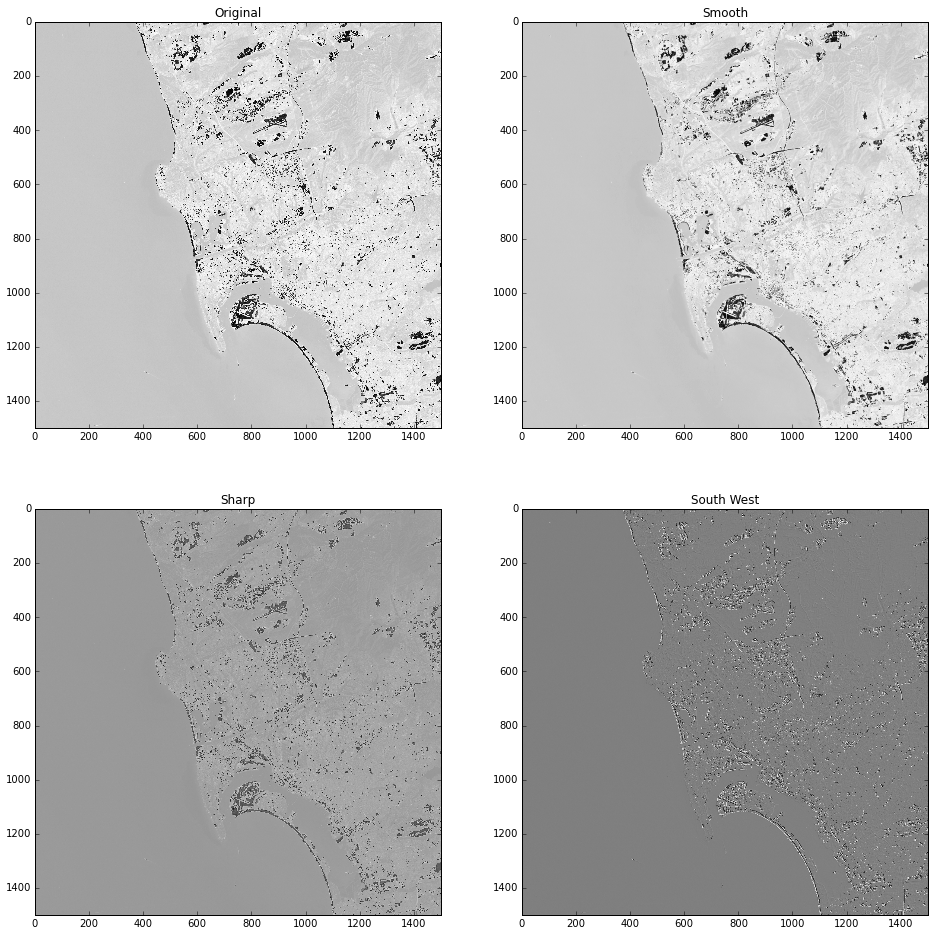

In [72]:
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(band1, cmap=cm.gray)
plt.title('Original')
plt.subplot(222)
plt.imshow(band1_smooth, cmap=cm.gray)
plt.title('Smooth')
plt.subplot(223)
plt.imshow(band1_sharp, cmap=cm.gray)
plt.title('Sharp')
plt.subplot(224)
plt.imshow(band1_sw, cmap=cm.gray)
plt.title('South West')
plt.savefig('band1_filtering.png', dpi=400)

## Exercise 5

#### The image looks fairly similar to the same region shown on GoogleEarth. The whole area has a pretty low vegetation index, but if we zoom in we can spot a few golf courses and valleys with relatively high vegetation indexes that are somewhat masked by the poor constrast distribution of the image.

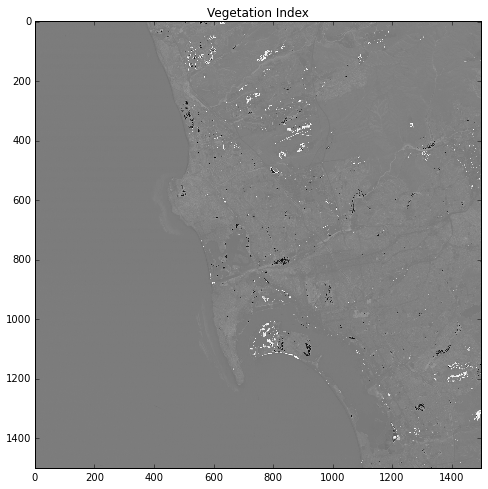

In [77]:
band3 = '/Users/bia/work/PhD/coursework/Spring2016/SIO236/labs/lab05/band3c.raw'
fbin3 = np.fromfile(band3,dtype='int8')
red = np.array(np.reshape(fbin3, (1500,1500)), dtype='double')+128

band4 = '/Users/bia/work/PhD/coursework/Spring2016/SIO236/labs/lab05/band4c.raw'
fbin4 = np.fromfile(band4,dtype='int8')
infra_red = np.array(np.reshape(fbin4, (1500,1500)), dtype='double') +128

NDVI = (infra_red - red)/(infra_red + red)

plt.figure(figsize=(8,8))
plt.imshow(NDVI, cmap=cm.gray)
plt.title('Vegetation Index')
plt.savefig('vegetation_index.png', dpi=300)